In [1]:
import numpy as np
import lbg_forecast.dust_priors as dpr
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt
import lbg_forecast.priors_gp as gp

(-2.2, 0.4)

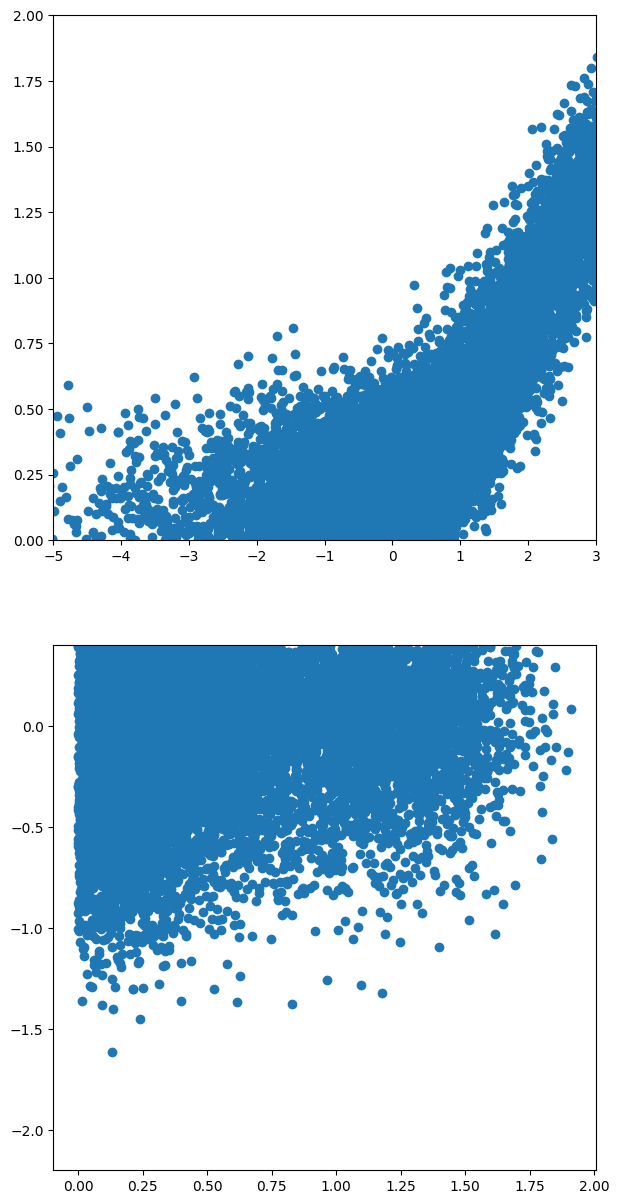

In [37]:
diffuse_dust_prior = gp.DiffuseDustPrior()
index_prior = gp.DustIndexPrior()

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))
ax1 = ax[0]
ax2 = ax[1]

nsamples = 10000
redshift = np.random.uniform(0, 7, nsamples)
logmass = np.random.uniform(7, 13, nsamples)
logsfrratios = pop.modified_prospector_beta_sfh_prior(redshift, logmass, 0.3)
recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshift, 10**logmass, logsfrratios))

#logsfr = np.random.uniform(-5.0, 3.0, 10000)

dust2_av = diffuse_dust_prior.sample_dust2(recent_sfrs)
dust_index = index_prior.sample_dust_index(dust2_av)

ax1.scatter(recent_sfrs, dust2_av)
ax1.set_ylim(0.0, 2.0)
ax1.set_xlim(-5.0, 3.0)

ax2.scatter(dust2_av, dust_index)
ax2.set_ylim(-2.2, 0.4)

In [71]:
np.atleast_2d(logsfrratios[0, :])

array([[-0.40834847,  0.13821356, -0.24517536,  0.51147049,  0.20317089,
         4.50234584]])

In [2]:
nsamples=10000
redshift = np.random.uniform(0, 2, nsamples)
mass = np.random.uniform(7, 13, nsamples)
log_sfr_ratios = np.random.uniform(-5, 5, (nsamples, 6))

Text(0.5, 0, 'diffuse dust')

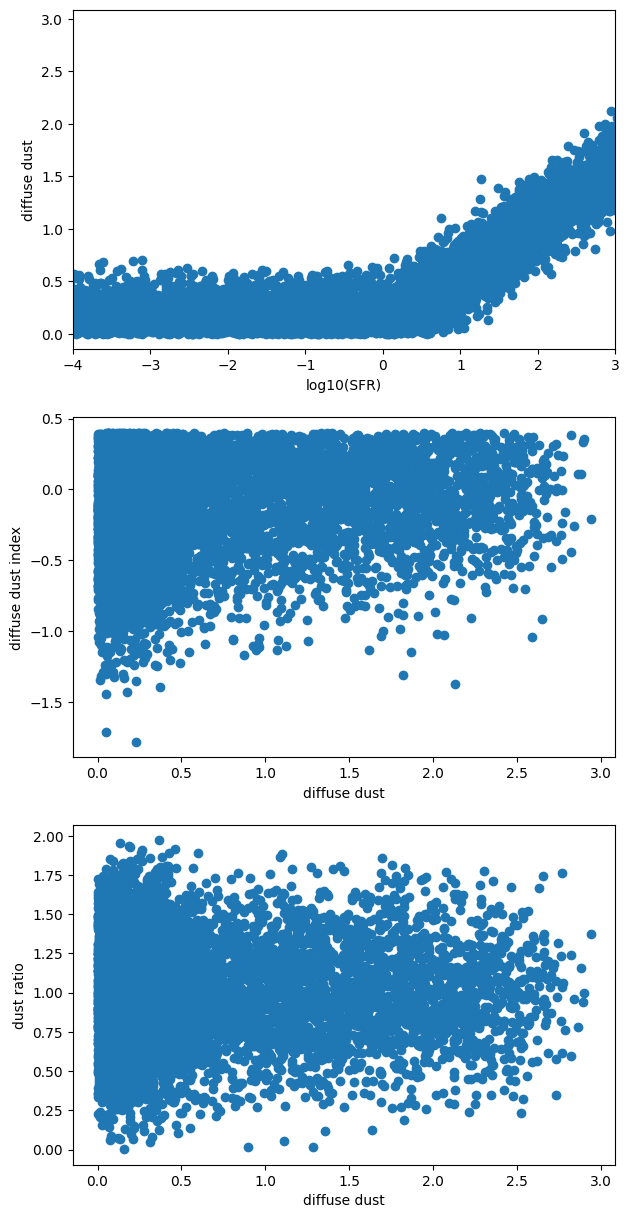

In [3]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(7, 15))

dust2, dust_index, dust_ratio, recent_sfrs = dpr.sample_dust_priors(redshift, mass, log_sfr_ratios)

axes[0].scatter(np.log10(recent_sfrs), dust2)
axes[0].set_xlim(-4, 3)
axes[0].set_xlabel("log10(SFR)")
axes[0].set_ylabel("diffuse dust")

axes[1].scatter(dust2, dust_index)
axes[1].set_ylabel("diffuse dust index")
axes[1].set_xlabel("diffuse dust")

axes[2].scatter(dust2, dust_ratio)
axes[2].set_ylabel("dust ratio")
axes[2].set_xlabel("diffuse dust")